In [52]:
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import pandas as pd

from popy.io_tools import *
from popy.behavior_data_tools import *
from popy.neural_data_tools import time_normalize_session, scale_neural_data, remove_low_fr_neurons, remove_trunctuated_neurons
from popy.decoders import *
from popy.plotting_tools import *

from decoder_tools import *

# event times
def get_event_times(neural_data):
    n_temp = neural_data[:, neural_data.trial_id==neural_data.trial_id[0]]
    bin_size = neural_data.attrs['bin_size']
    epochs = np.unique(n_temp.epoch_id.values)
    ep_lens = np.array([len(n_temp[:, n_temp.epoch_id==epoch].time) for epoch in epochs])
    ep_lens = ep_lens * bin_size
    ep_lens = np.cumsum(ep_lens)
    ep_lens = np.insert(ep_lens, 0, 0)

    events = {'trial_start': ep_lens[0], 
              'lever_touch': ep_lens[1],
              'lever_validation': ep_lens[2],
              'target_touch': ep_lens[3],
              'target_validation': ep_lens[4],
              'feedback': ep_lens[5],
              'trial_end': ep_lens[6]}

    return events

# Load and fromat data

In [53]:
monkey, session = 'ka', '030322'
area = 'LPFC'

## Behav data

In [54]:
session_data = get_behavior(monkey, session)

In [55]:
# clean up data
session_data = drop_time_fields(session_data)  # remove time fields
session_data = session_data.drop(['block_id', 'best_target'], axis=1)  # drop block_id and best_target
session_data = session_data.dropna()
session_data.head(10)

,trial_id,target,feedback
0,0,2,False
1,1,2,False
2,2,3,False
3,3,1,True
4,4,1,True
5,5,1,True
6,6,1,False
7,7,1,True
8,8,1,True
9,9,1,False


## Neural data

In [56]:
import popy.config as cfg

# Load neural data
out_path = os.path.join(cfg.PROJECT_PATH_LOCAL, 'data', 'processed', 'rates')
floc = os.path.join(out_path, f'neural_data_{monkey}_{session}.nc')
neural_data = xr.open_dataarray(floc)

neural_data

<xarray.DataArray (unit: 32, time: 316500)>
[10128000 values with dtype=float32]
Coordinates:
    trial_id          (time) float64 ...
    epoch_id          (time) float64 ...
  * time              (time) float64 20.63 20.77 20.92 ... 3.191e+03 3.191e+03
  * unit              (unit) object 'MCC_08_01' 'MCC_08_02' ... 'LPFC_13_03'
    area              (unit) object ...
    unit_id_original  (unit) int32 ...
    channel           (unit) int32 ...
Attributes:
    bin_size:  0.01

## Match behav and neural trials

In [57]:
# only shared ids
neural_trials = neural_data.trial_id.values
behav_trials = session_data.trial_id.values
shared_trials = np.intersect1d(neural_trials, behav_trials)

neural_data = neural_data[:, neural_data.trial_id.isin(shared_trials)]
session_data = session_data[session_data.trial_id.isin(shared_trials)]

## Create dataset

In [58]:
# create dataset
neural_data_np = np.array([
    neural_data[:, np.where(neural_data.trial_id.data == trial)[0]]
    for trial in shared_trials])

neural_data_np.shape

(422, 32, 750)

# Find fb subspace

In [59]:
def run_decoder_method(neural_data, session_data, mode, variables_to_decode, areas_to_decode, window_len, step_len, start_on, end_on):
    # df to store results
    all_scores = pd.DataFrame(columns=variables_to_decode, # ['feedback', 'value_function']'value_function', 'RPE', 'switch',  # , 'phase', 'target_1', 'target_2', "target_3"
                            index=areas_to_decode)#, 'both'

    # add new column for rpe
    for target_name in variables_to_decode:
        for area in areas_to_decode:
            print(f"Decoding {target_name} in {area} area")
            all_scores[target_name][area] = linear_decoding(neural_data, session_data, target_name, mode=mode, area=area,
                                                            starts_on=start_on, ends_on=end_on,
                                                            window_len=window_len, step_len=step_len, return_p_values=True)
            
    return all_scores

In [60]:
variables_to_decode = ['feedback']
areas_to_decode = ['MCC', 'LPFC']

# set parameters for decoding
window_len, step_len = .2, .01
start_on, end_on = 'trial_start', 'trial_end'

mode = 'time_resolved'

"""neural_data_diff = neural_data.diff('time')
neural_data_diff.attrs = neural_data.attrs"""

# run decoder
all_scores = run_decoder_method(neural_data, session_data, mode, variables_to_decode, areas_to_decode, 
                                window_len, step_len, start_on, end_on)
#all_scores_across['meta'] = [monkey, session]
all_scores

Decoding feedback in MCC area


 27%|██▋       | 198/730 [04:03<10:55,  1.23s/it]

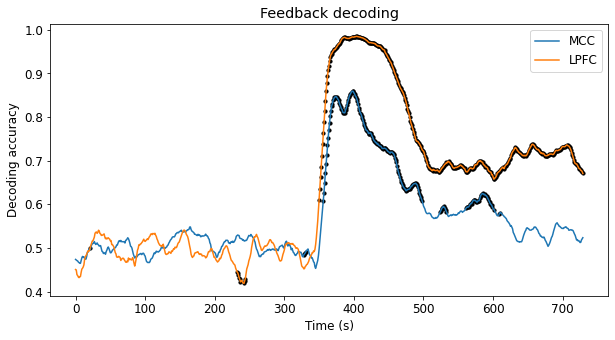

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for area in areas_to_decode:
    scores = all_scores['feedback'][area][0]
    p_values = all_scores['feedback'][area][1]
    ax.plot(scores, label=area)
    # dot at p < .05
    ax.scatter(np.where(p_values < .0005)[0], scores[p_values < .0005], color='black', s=10)
    ax.set_title('Feedback decoding')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Decoding accuracy')
    ax.legend()


In [ ]:
# bonferonni correction
p_correct = .05 / len(p_values)

for area in areas_to_decode:
    # first index where p < p_correct for 10 consecutive bins
    p_values = all_scores['feedback'][area][1]

    signif_bins = p_values < p_correct

    ten_bin_ids = np.empty(len(signif_bins)-10)

    for i in range(len(ten_bin_ids)):
        ten_bin_ids[i] = np.sum(signif_bins[i:i+10]) == 10

    first_bin = np.where(ten_bin_ids)[0][0]

    print(area, first_bin)


MCC 357
LPFC 351
